# Traceable Build

Embedded flash file build script, documentation, & tests.

## Generate universally unique identifier

Generate a UUID for this instance of the documentation, build, and tests.

> From Wikipedia, the free encyclopedia
A universally unique identifier (UUID) is a 128-bit number used to identify information in computer systems. The term globally unique identifier (GUID) is also used.

> When generated according to the standard methods, UUIDs are for practical purposes unique, without depending for their uniqueness on a central registration authority or coordination between the parties generating them, unlike most other numbering schemes. While the probability that a UUID will be duplicated is not zero, it is close enough to zero to be negligible.

> Thus, anyone can create a UUID and use it to identify something with near certainty that the identifier does not duplicate one that has already been, or will be, created to identify something else. **Information labeled with UUIDs by independent parties can therefore be later combined into a single database, or transmitted on the same channel, without needing to resolve conflicts between identifiers**.

> Adoption of UUIDs and GUIDs is widespread, with many computing platforms providing support for generating them, and for parsing their textual representation.

- https://en.wikipedia.org/wiki/Universally_unique_identifier

In [6]:
import uuid
build_uuid = str(uuid.uuid4())
print("Build UUID: {}".format(build_uuid))

Build UUID: 3a761187-4bd5-4ebc-bc97-54445a296c5c


In [8]:
# Imports for build.
import glob
import uuid
import jinja2
import os
import re
import time
import datetime

In [9]:
# Checkpoints. Timestamps of what occured when.
checkpoints=list()
def checkpoint():
    now=datetime.datetime.utcnow().replace(tzinfo=datetime.timezone.utc).isoformat()
    checkpoints.append(now)
    print("Checkpoint {:02d}: {}".format(len(checkpoints), now))
checkpoint()

Checkpoint 01: 2018-05-17T18:53:10.033674+00:00


## Build Environment

Build environment, for tracability. 

In [10]:
!uname -a

Linux m6700 4.15.0-13-generic #14-Ubuntu SMP Sat Mar 17 13:44:27 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux


In [11]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04 LTS
Release:	18.04
Codename:	bionic


In [12]:
!hostname

m6700


In [13]:
!whoami

jed


# Source Code

Source code template for the flash file and Makefile.

### Arduino Sketch Code Template

In [16]:
arduino_template_str = """
unsigned long BAUD = {{ baud }};
unsigned long DELAY = {{ delay }};
char BUILD_UUID[] = "{{ build_uuid }}";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
Serial.begin(BAUD);
Serial.print("Build UUID: ");
Serial.println(BUILD_UUID);

// Start of frame
Serial.write(0xAA);

// Timestamp
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// DLC
Serial.write(0x00);

// Arbitration ID
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// End of frame
Serial.write(0xBB);
return; 
}

// Arduino Main Loop
void loop() {

/* Begin timestamp data packet */
time_millis = millis();
// Start of frame
Serial.write(0xAA);

// Timestamp
timestamp = time_millis;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)timestamp>>shift&0b11111111);
}

// DLC
Serial.write(0x04);
// Arbitration ID
arbitration_id=1;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)arbitration_id>>shift&0xFF);
}

// Payload
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)time_millis>>shift&0b11111111);
}

// End of Frame
Serial.write(0xBB);
/* End timestamp data packet */

/* Begin sinewave data packet */
time_millis = millis();
// Start of frame
Serial.write(0xAA);

// Timestamp
timestamp = time_millis;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)timestamp>>shift&0b11111111);
}

// DLC
Serial.write(0x04);
// Arbitration ID
arbitration_id=2;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)arbitration_id>>shift&0xFF);
}

#include <math.h>

int32_t sine_value = pow(2, 31)*(sin(1000*(float)timestamp));

// Payload
for(char shift=0;shift<32;shift+=8) {
Serial.write(sine_value>>shift&0b11111111);
}

// End of Frame
Serial.write(0xBB);
/* End sinewave data packet */
}
"""

### Makefile Code Template

In [17]:
makefile_template_str = """
BOARD_TAG:={{ board_tag }}
ARDUINO_DIR:={{ arduino_dir }}
ARDMK_DIR:={{ ardmk_dir }}
ARCHITECTURE:={{ architecture }}

include ${ARDMK_DIR}/Arduino.mk
"""

Generate Jinja2 template objects from the template strings.

In [18]:
arduino_template = jinja2.Template(arduino_template_str)
makefile_template = jinja2.Template(makefile_template_str)

In [19]:
checkpoint()

Checkpoint 02: 2018-05-17T18:59:09.539505+00:00


## Source Configuration

Configuration options for the flash file and build.

Can be read from ConfigParser, JSON, XML, databases.

In [26]:
build_cfg=dict()
build_cfg["baud"] = 115200
build_cfg["delay"]= 0
build_cfg["build_uuid"]=build_uuid

build_cfg["board_tag"]="nano328"
build_cfg["architecture"]="avr"

build_cfg["arduino_dir"]=os.path.abspath(os.path.join("..", "arduino"))
build_cfg["ardmk_dir"]=os.path.abspath(os.path.join("..", "arduino_make"))

## Generate Build Source Code

Apply the template

In [27]:
arduino_sketch_src = (arduino_template.render(**build_cfg))
makefile_src = (makefile_template.render(**build_cfg))

In [28]:
print(arduino_sketch_src)
sketch_file = "{}.ino".format(build_uuid)
with open(sketch_file, "w") as fid:
    fid.write(arduino_sketch_src)


unsigned long BAUD = 115200;
unsigned long DELAY = 0;
char BUILD_UUID[] = "3a761187-4bd5-4ebc-bc97-54445a296c5c";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
Serial.begin(BAUD);
Serial.print("Build UUID: ");
Serial.println(BUILD_UUID);

// Start of frame
Serial.write(0xAA);

// Timestamp
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// DLC
Serial.write(0x00);

// Arbitration ID
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);
Serial.write(0x00);

// End of frame
Serial.write(0xBB);
return; 
}

// Arduino Main Loop
void loop() {

/* Begin timestamp data packet */
time_millis = millis();
// Start of frame
Serial.write(0xAA);

// Timestamp
timestamp = time_millis;
for(char shift=0;shift<32;shift+=8) {
Serial.write((unsigned long)timestamp>>shift&0b11111111);
}

// DLC

## Formatting.

Format the sketch to adhere to LLVM style guidelines.

In [29]:
import subprocess
subprocess.check_output(["clang-format-6.0", "-style=LLVM", "-i", sketch_file])

b''

Cleaned source code, formated with LLVM style guidelines.

In [30]:
with open(sketch_file, "rb") as fid:
    arduino_sketch_formatted = fid.read()    
print(arduino_sketch_formatted.decode("UTF-8"))


unsigned long BAUD = 115200;
unsigned long DELAY = 0;
char BUILD_UUID[] = "3a761187-4bd5-4ebc-bc97-54445a296c5c";

unsigned long arbitration_id = 0x0;
unsigned long time_millis = 0b0;
unsigned long timestamp = 0x0;

uint8_t counter8 = 0x00;
uint16_t counter16 = 0x0000;
uint32_t counter32 = 0x00000000;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);

  // Start of frame
  Serial.write(0xAA);

  // Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);

  // DLC
  Serial.write(0x00);

  // Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);

  // End of frame
  Serial.write(0xBB);
  return;
}

// Arduino Main Loop
void loop() {

  /* Begin timestamp data packet */
  time_millis = millis();
  // Start of frame
  Serial.write(0xAA);

  // Timestamp
  timestamp = time_millis;
  for (char shift = 0; shift < 32; shift += 8) {
    S

## Traceability

Checksum of the formatted source code, before compilation. Add to blockchain for an immutable proof of existence when it was generated, for tracability.

In [369]:
import hashlib
for algo in hashlib.algorithms_guaranteed:
    sketch_hash = getattr(hashlib, algo)(arduino_sketch_formatted)
    try:
        print("{}: {}".format(algo, sketch_hash.hexdigest()))
    except:
        pass

sha3_256: 0048d67bb1b742213b0bfb9ea3aa6953e29eed77c9ac9d02e3cd5f3ebedc5409
blake2b: 288da238367b3d93c569584814c3d163cf8568e0b662d27f3b766e609bf21fe3189c42a5bfb4051063945500e695d70b5cc03dc55597d51463a8644972507af0
md5: a3738b682a7bcfdf43ba45c1e5a8e7a7
sha1: 229078b8a3cce4089f2eed9e692d8f983f497f31
sha224: 607f0def5d97ed076cfd6f28615cb07a8309db6496ef970d871331d6
sha3_224: 222a868dac940c88732d5535a5fda5606033d15185a4e5cb97971d16
sha3_512: b2d651266241df6165734c10a806cc316102c51f42e15053b23c7304bce5b2dd12695d3508291da98077acc6536e6fe12e5bf1eb059ddd993a705d4a4a3e9bfa
sha256: 47c60e4e52e90e5278c76552351c96ff54a62cac8e0a9d1ea2793448667bf7de
blake2s: 49d72c565a59e630e77bd97d5be2c3305866bcd69469d3985553cb69dc0764f8
sha3_384: e258b49991161b699f6e2cf15cf3f8a81e8730a03c083e2f9622469e89d73e935c5c3c535df2d3b008b26f96df031b22
sha384: 19a28b6eace44b9bc0cae1eaf994f6d8360ce1445e8b1db7d67c4bf0bdaef4eaf94c1d77d53859d1b302cf101c6de308
sha512: 550ae729430d4600f9203901f5d0d3b7bb1bfcd777af4fb2f88266a18c6e3a3b

In [370]:
checkpoint()

2018-05-17T02:18:31.781218+00:00


# Build Process

## Build & Upload Flash File

In [371]:
import serial
import time

In [372]:
try:
    stdout = subprocess.check_output(["make", "upload"]).decode()
    print(stdout)
except subprocess.CalledProcessError as err:
    print("Build Failed:")
    print(err)
except:
    raise

-------------------------
Arduino.mk Configuration:
- [AUTODETECTED]       CURRENT_OS = LINUX 
- [AUTODETECTED]       ARDUINO_DIR = /usr/share/arduino 
- [COMPUTED]           ARDMK_DIR = /projects/arduino_IO/arduino_make (relative to Common.mk)
- [AUTODETECTED]       ARDUINO_VERSION = 105 
- [DEFAULT]            ARCHITECTURE =  
- [DEFAULT]            ARDMK_VENDOR = arduino 
- [AUTODETECTED]       ARDUINO_PREFERENCES_PATH = /mnt/ubuntu1604_2/home/jed/.arduino/preferences.txt 
- [AUTODETECTED]       ARDUINO_SKETCHBOOK = /mnt/ubuntu1604_2/home/jed/sketchbook (from arduino preferences file)
- [BUNDLED]            AVR_TOOLS_DIR = /usr/share/arduino/hardware/tools/avr (in Arduino distribution)
- [COMPUTED]           ARDUINO_LIB_PATH = /usr/share/arduino/libraries (from ARDUINO_DIR)
- [COMPUTED]           ARDUINO_VAR_PATH = /usr/share/arduino/hardware/arduino//variants (from ARDUINO_DIR)
- [COMPUTED]           BOARDS_TXT = /usr/share/arduino/hardware/arduino//boards.txt (from ARDUINO_DIR)
- 

In [374]:
checkpoint()

2018-05-17T02:28:09.047157+00:00


## Build Process Tests

Make sure that all serial ports from the build and upload process are the same.

In [375]:
serial_ports = re.compile("(/dev/ttyUSB[\d]+)").findall(stdout)
serial_ports

['/dev/ttyUSB2', '/dev/ttyUSB2', '/dev/ttyUSB2']

In [344]:
for i in range(len(serial_ports)-1):
    assert (serial_ports[i] == serial_ports[i+1])

In [345]:
checkpoint()

2018-05-17T02:15:04.733424+00:00


# Flashfile Testing 

V&V on the flashfile that was just built.

In [216]:
import serial
import time

In [217]:
ser = serial.Serial(
    port=serial_ports[0], baudrate=sketch_cfg["baud"],
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=10,
    xonxoff=0,
    rtscts=0
)

In [218]:
checkpoint()

2018-05-17T01:47:19.291341+00:00


### Build & Flash UUID verification

Assert that the UUID generated from the build script is the same one that is being reported back from the HIL flash file.

In [219]:
ser.setDTR(False) # Drop DTR
time.sleep(1)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.flushOutput()
ser.flush()
ser.setDTR(True)  # UP the DTR back
header = ser.readline()
header

b'Build UUID: e67613ed-a01f-4a80-9200-ea2802b6db25\r\n'

In [220]:
header_uuid = header.split(b"UUID:")[1].strip().decode("UTF-8")

In [221]:
build_uuid

'e67613ed-a01f-4a80-9200-ea2802b6db25'

In [222]:
header_uuid

'e67613ed-a01f-4a80-9200-ea2802b6db25'

In [223]:
assert build_uuid == header_uuid

In [224]:
checkpoint()

2018-05-17T01:47:21.797830+00:00


## Packet validation.

Test that the CAN over Serial packets are being sent correctly.

Check that the configuration values also match.

In [225]:
ser.read_until(b"\xAA")
for x in range(10):
    packet = ser.read_until(b"\xBB")
    print(packet)

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbb'
b'\xaa\x01\x00\x00\x00\x04\x01\x00\x00\x00\x01\x00\x00\x00\xbb'
b'\xaa\x01\x00\x00\x00\x04\x02\x00\x00\x00\x00R\xb5k\xbb'
b'\xaa\x02\x00\x00\x00\x04\x01\x00\x00\x00\x02\x00\x00\x00\xbb'
b'\xaa\x03\x00\x00\x00\x04\x02\x00\x00\x00`8\x10\x12\xbb'
b'\xaa\x04\x00\x00\x00\x04\x01\x00\x00\x00\x04\x00\x00\x00\xbb'
b'\xaa\x06\x00\x00\x00\x04\x02\x00\x00\x00\x00\x1d<\xdc\xbb'
b'\xaa\x07\x00\x00\x00\x04\x01\x00\x00\x00\x07\x00\x00\x00\xbb'
b'\xaa\x08\x00\x00\x00\x04\x02\x00\x00\x00\x00J\xa3~\xbb'
b'\xaa\t\x00\x00\x00\x04\x01\x00\x00\x00\t\x00\x00\x00\xbb'


In [226]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x0b\x00\x00\x00\x04\x02\x00\x00\x00\x80R\x00\x80\xbb'

In [227]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x0c\x00\x00\x00\x04\x01\x00\x00\x00\x0c\x00\x00\x00\xbb'

In [228]:
packet[1:5]

b'\x0c\x00\x00\x00'

In [229]:
timestamp_raw = packet[1:5]
timestamp_raw

b'\x0c\x00\x00\x00'

In [230]:
int.from_bytes(timestamp_raw, 'little')

12

In [231]:
int.from_bytes(timestamp_raw, 'big')

201326592

In [232]:
timestamp = int.from_bytes(timestamp_raw, 'little')
timestamp

12

In [233]:
sof = packet[0]
sof

170

In [234]:
int.from_bytes(b'\xAA', 'little')

170

In [235]:
int.from_bytes(b'\xAA', 'big')

170

In [236]:
assert sof == int.from_bytes(b'\xAA', 'little')

In [237]:
dlc = packet[5]
dlc

4

In [238]:
arbitration_id_raw = packet[6:10]
arbitration_id_raw

b'\x01\x00\x00\x00'

In [239]:
int.from_bytes(arbitration_id_raw, 'little')

1

In [240]:
int.from_bytes(arbitration_id_raw, 'big')

16777216

In [241]:
data = packet[11]
data 

0

In [242]:
sketch_cfg

{'baud': 115200,
 'delay': 10,
 'build_uuid': 'e67613ed-a01f-4a80-9200-ea2802b6db25'}

In [243]:
header_uuid

'e67613ed-a01f-4a80-9200-ea2802b6db25'

In [244]:
sketch_cfg["build_uuid"]

'e67613ed-a01f-4a80-9200-ea2802b6db25'

In [245]:
assert str(header_uuid) == header_uuid

In [246]:
assert str(sketch_cfg["build_uuid"]) == sketch_cfg["build_uuid"]

In [247]:
assert header_uuid == sketch_cfg["build_uuid"]

In [248]:
ser.close()

# python-can testing

Validate and verify that ``python-can`` is decoding the packets correctly.

In [376]:
import can
can.__version__

'2.1.0'

In [380]:
bus_cfg = dict()
bus_cfg["bustype"] = "serial"
bus_cfg["channel"]=serial_ports[0]
bus_cfg["bitrate"]=115200

bus = can.interface.Bus(**bus_cfg)   
bus.ser.read_until(b"\xBB")

b'\x00\x04\x02\x00\x00\x00\x80\x92\xbc@\xbb'

In [381]:
packet = bus.recv()
packet

can.Message(timestamp=1.572, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x24, 0x6, 0x0, 0x0])

In [382]:
packet.timestamp

1.572

In [383]:
packet.arbitration_id

1

In [384]:
packet.dlc

4

In [385]:
packet.data

bytearray(b'$\x06\x00\x00')

In [386]:
int.from_bytes(packet.data, 'little')

1572

In [387]:
int.from_bytes(packet.data, 'big')

604372992

In [388]:
packet.timestamp

1.572

In [389]:
packet

can.Message(timestamp=1.572, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0x1, dlc=4, data=[0x24, 0x6, 0x0, 0x0])

In [390]:
packets = list()
time_packets = list()
while len(packets)<5000:
    packet = bus.recv()
    
    if packet is None:
        time.sleep(0.01)
        continue
    if packet.arbitration_id == 1:
        time_packets.append(packet)
    if packet.arbitration_id == 2:
        packets.append(packet)

In [391]:
class Data(object):
    def __init__(self, ):
        
        pass
data = Data()

In [395]:
data.time = [packet.timestamp for packet in time_packets]
data.time[:10]

[1.574, 1.577, 1.58, 1.583, 1.585, 1.588, 1.59, 1.593, 1.595, 1.598]

In [396]:
data.values = [int.from_bytes(packet.data, 'little', signed=True) for packet in time_packets]
data.values[:10]

[1574, 1577, 1580, 1583, 1585, 1588, 1590, 1593, 1595, 1598]

## Visual Test

Plot of data.

Data is a sine wave.

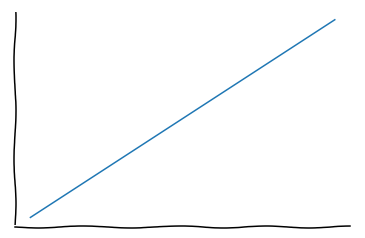

In [399]:
import matplotlib.pyplot as plt
plt.xkcd()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(data.time, data.values)

# Appendices

## Python Module Versions

In [198]:
!pip freeze

backcall==0.1.0
bleach==2.1.3
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
html5lib==1.0.1
ipykernel==4.8.2
ipython==6.4.0
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
kiwisolver==1.0.1
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.5.0
numpy==1.14.3
pandas==0.23.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
pkg-resources==0.0.0
prompt-toolkit==1.0.15
ptyprocess==0.5.2
Pygments==2.2.0
pyparsing==2.2.0
pyserial==3.4
python-can==2.1.0
python-dateutil==2.7.3
pytz==2018.4
pyzmq==17.0.0
qtconsole==4.3.1
scipy==1.1.0
seaborn==0.8.1
Send2Trash==1.5.0
simplegeneric==0.8.1
six==1.11.0
terminado==0.8.1
testpath==0.3.1
tornado==5.0.2
traitlets==4.3.2
wcwidth==0.1.7
webencodings==0.5.1
widgetsnbextension==3.2.1
